In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
import matplotlib as mpl
from ipywidgets import interactive


In [2]:
from platform import python_version
print('Running on pyMC3 v{}'.format(pm.__version__))
print('Running Python version v{}'.format(python_version()))

Running on pyMC3 v3.7
Running Python version v3.7.4


## Overdose Model

We assume the following:  

Underlying log rate follows Normal distribution.
$$z_{t} \sim N(\mu, \sigma^{2})$$  

Overdose rate is deterministic variable that exponentiates log rate.
$$\lambda_{t}^{OD} = \exp(z_{t})$$

Overdoses follows Poission distribution.
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$


Our interest is the overdoses. The number of overdoses is not easy to obtain in the real world so we estimate.
We set N=10000.
we obtain 1000 samples of parameters and posterior predictive samples and plot them with the observation.

Think of overdose per a year where t= 1,2,3, ..., 12.
We need a vector of z_t to generate a vector of overdoses. 

We set for our prior parameters: $$\mu=-4, \sigma=1$$.

In [4]:
import random
random.seed(1)
N = 10000
z_t = np.random.normal(loc=-4, scale=1, size = 12)
o_t = np.random.poisson(lam=(np.exp(z_t)*N))
print('Vector z_t: ', z_t)
print('Vector o_t: ', o_t)


Vector z_t:  [-4.1287515  -3.5400672  -3.03066988 -3.0288877  -3.0514219  -2.91056682
 -3.13218233 -3.82793674 -4.54000218 -4.13959565 -4.39031279 -3.3984414 ]
Vector o_t:  [165 331 500 503 469 544 441 221 115 176 117 307]


Now we have our vector of observations.
Before fitting a model to the data, let's assume that $p(\mu)$ and $p(\sigma^2)$ is noninformative, say uniform.
$$p(\mu) = U(-10, 10)$$  
$$p(\sigma) = U(0, 3)$$  
Let's fit the model to the data o_t.  
Note: prior of variance is inverse Gamma, Cauchy (informative) or Uniform, Half Normal (noninformative).

In [7]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower = -10, upper= 10)
    sigma = pm.Uniform('sigma', lower = 0, upper= 10)
    z_t =pm.Normal('z_t',mu=mu, sigma=sigma, shape = (12,))
    
    x = pm.Poisson('o_t', mu=tt.exp(z_t)*N, shape=(12,), observed=o_t)
    

In [9]:
with model:
    trace =pm.sample(1000)
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z_t, sigma, mu]
100%|██████████| 2000/2000 [00:02<00:00, 908.49it/s]


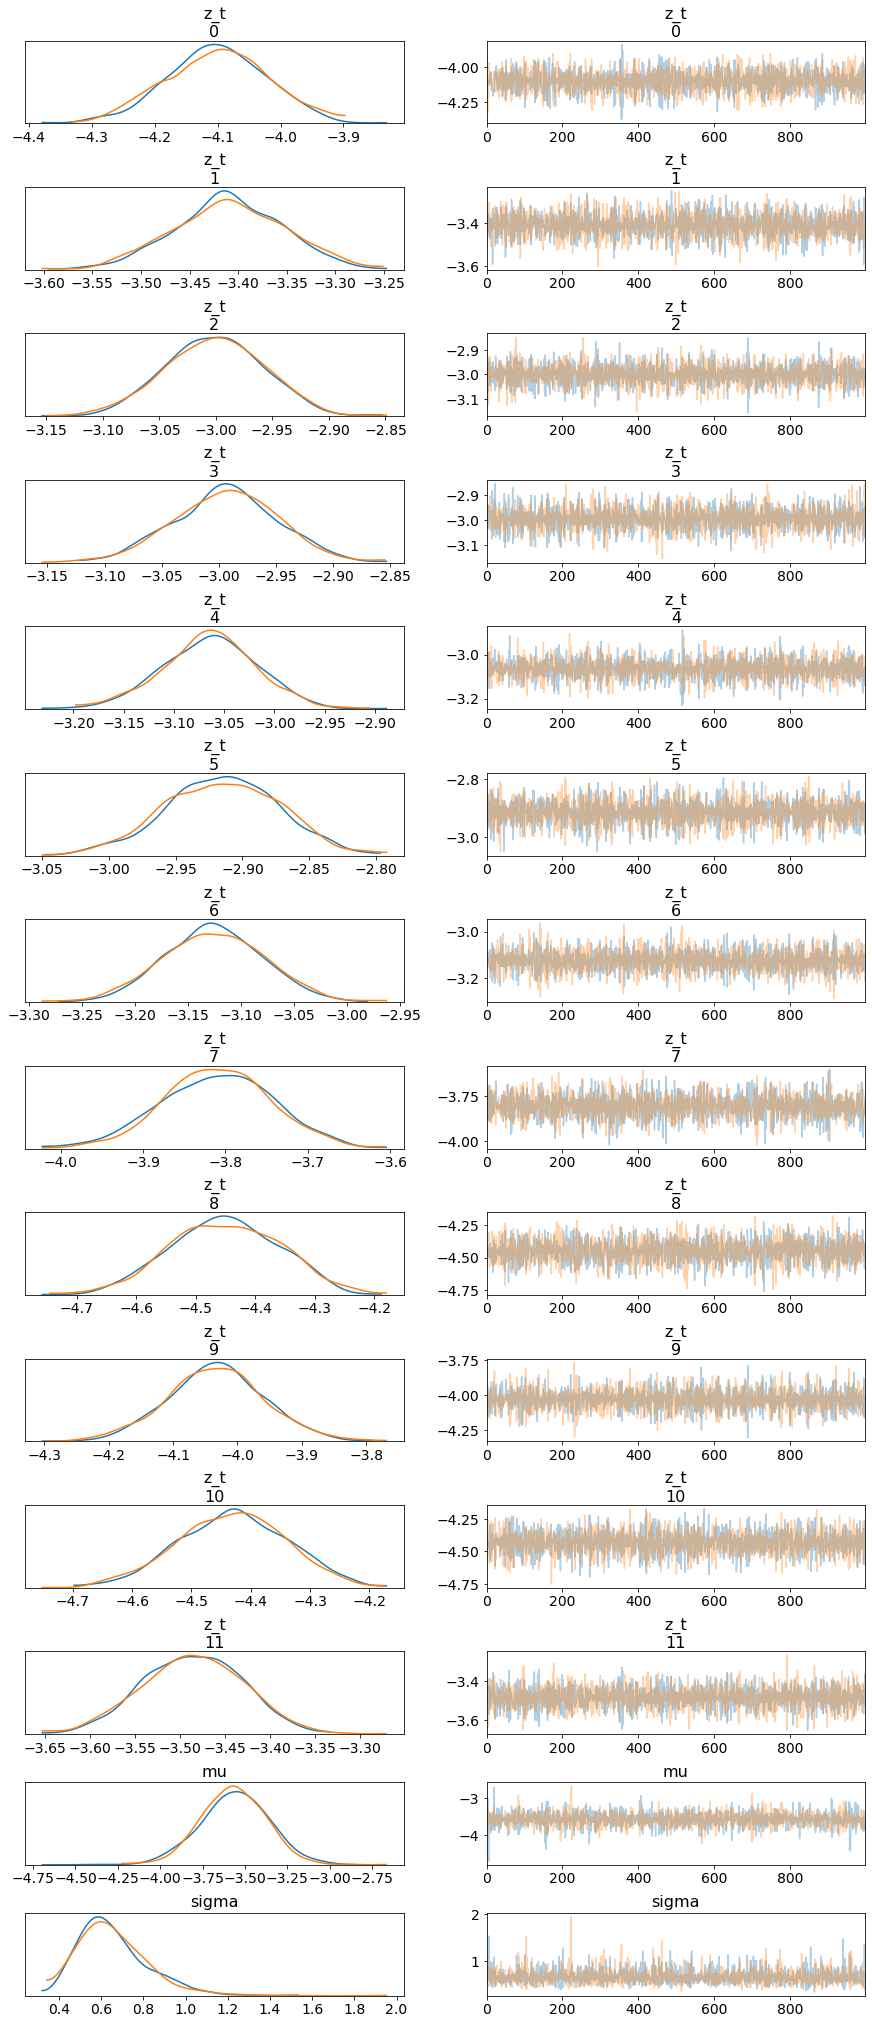

In [11]:
pm.traceplot(trace);

Dispersed prior led $\mu$ over-estimated and $\sigma$ under-estimated.   
The mean of prior $E(\mu)=0$ seems to lead the posterior mean toward 0.  
$ E(\sigma)= 9/12 \approx 0.75$ and the posterior sigma is less than the true value.

In [12]:
# For EDA
def plot_data_timeseries(ys, xs=None, xlabel="Month", ylabel="Overdoses", new_plot=True, color="#E14A33", label=None):
    
    '''
    brief intro: plot 95 and IQR
    parameters:
    -----
    ys: sample size by time numpy array 
    xs: x axis as time
    xlabel: string
    ylabel: string
    new_plot: boolean
        plotting to a new figure or not
    color: str
    label: str
    return
    -----
    
    
    '''
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
    
    if new_plot: plt.figure;
        # if we wanna make a new plot, then by using plt.figure function,
        # we create a new plot figure
        
    lc, liqr, m, uiqr, uc = np.percentile(ys, [2.5,25,50,75,97.5], axis=0);
    # now it's time to use the (already) existing plot figure
    plt.fill_between(xs, lc, uc,alpha=0.2 ,color=color);
    plt.fill_between(xs, liqr, uiqr, color=color, alpha=0.2);
    plt.plot(xs,m, color= color, label = label);
    plt.xlabel(xlabel);plt.ylabel(ylabel);

# Ambulance Call-outs

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

We assume $n_{A}=0, 10, 100, 1000$ 
Suppose the prior of p is noninformative. 
$p(p) \sim Beta(1,1)$

(I got lost what can we do here with x and n for posterior of p)  
Assume that there was a survey that $n_A$ was the sample size of it.   
The true value of $p_A$ is postulated 0.8.  
We further suppose the people of the number of $x_A$ called the ambulance when the witnessed overdoses.   
Then $x_A \approx O_t$ for a given t.  

In [14]:
# Generate simulated data
p_a = 0.8


In [15]:
def ambulance_callouts(p_a=p_a, n_a=0):
    # Generate simulated data
    x = p_a*n_a
    
    # model definition
    with pm.Model() as model:
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        x_a = pm.Binomial('x_a', n=n_a, p=p_a, observed=x)
        
    return model

In [31]:
model_list =[] # two iterate objs!
trace_list=[]
ppc_list=[]
for i,j in enumerate([0,10,100,1000]):
    model = ambulance_callouts(n_a=j)
    model_list.append(model)
    with model_list[i]:
        trace = pm.sample(1000)
        trace_list.append(trace)
        ppc = pm.sample_posterior_predictive(trace)
        ppc_list.append(ppc)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2408.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2359.49it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2564.90it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2474.07it/s]


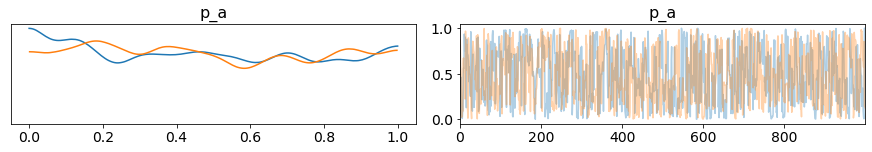

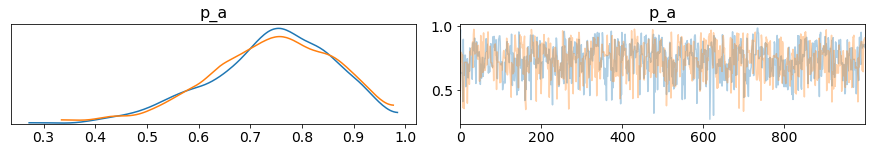

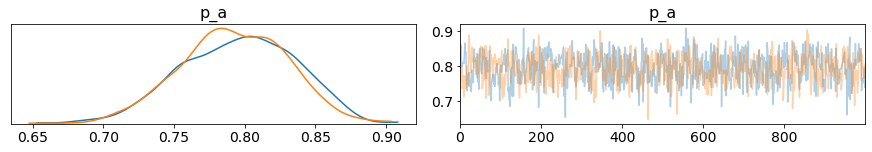

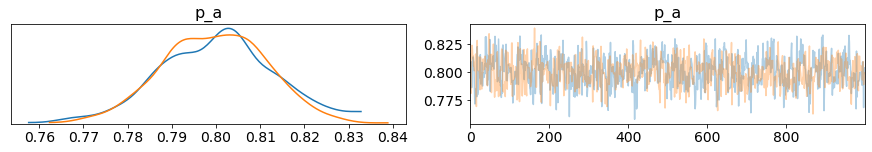

In [69]:
# fig, axs=plt.subplots(4,2)
for i in range(4):
    pm.traceplot(trace_list[i], trace_kwargs={'label':'label not showing'})